# Semantic Segmentation tutorial

This is a tutorial to demonstrate how to perform semantic segmentaiotn on images with deep learning in a few lines of code.

Data is collected from the self-driving car simulator [Carla simulator](http://carla.org/). The data is included in the repository for the tutorial. Nevertheless, make sure to check this cool open-sourced simulator if you are interested in exploring more different topics in perceptions for self-driving car

Let's first take a look at an image we are going to work with.

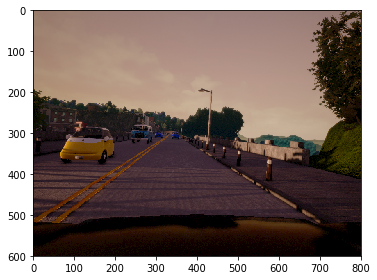

In [15]:
from skimage.io import imread, imshow, imsave
%matplotlib inline

img = imread("img/example.png")
imshow(img)

Since we are not going to make prediction for the hood and the sky, we can crop it off to make the training images smaller. The cropped images are stored in [hdf5](https://www.h5py.org/) format. There are two datasets in this file. One is _data/train_ and the other is _data/label_

number of images:  100


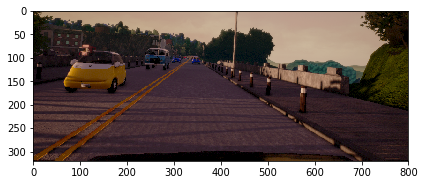

In [16]:
import h5py

with h5py.File("data.hdf5", "r") as hf:
    data = hf.get("train/data")
    img_part = data[0]
    imshow(img_part)
    print("number of images: ", len(data))


Let's take a quick look at the label. We are going to classify the pixels into 5 groups, which are

* Pedestrians:          1
* Roads:                2
* Vehicles:             3
* Traffic signs:        4
* Other than the above: 0

numnber of labels:  100


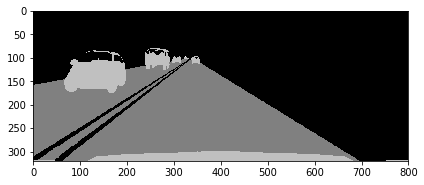

In [17]:
with h5py.File("data.hdf5", "r") as hf:
    data = hf.get("train/label")
    label = data[0]
    imshow(label/4)
    print("numnber of labels: ", len(data))

## Import the things we need 

In [ ]:
from keras.layers import Conv2D, Conv2DTranspose, Input, Lambda, MaxPooling2D, concatenate
from keras.models import Model
import numpy as np

## Define the model U-Net

U-Net is encoder-decoder style neural network. One feature to make it stand out is that it has many skip connections which help it predict better boundaries for the blobs. Feel free to change the number of kernels to suit your GPU or CPU

We input a random tensor to check the output shape

In [ ]:
inputs = Input((None, None, 3))

c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(5, (1, 1), activation='softmax') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

print("output shape: ", model.predict(np.random.random([1,320,800,3])).shape)

The following will show the structure of the model and count the total number of parameters

In [ ]:
model.summary()


## Prepare data
We are going to use **fit_generator** to train the model, so we map the data into the **Sequence** class. Also, we use **to_categorical** to transform the labels into one-hot encodings

In [ ]:
from keras.applications.xception import preprocess_input
from keras.utils import Sequence
import h5py
import numpy as np
from keras.utils import to_categorical


class RoadSequence(Sequence):

    def __init__(self, file_path, batch_size):
        super().__init__()
        hf = h5py.File(file_path)
        self.data = hf.get("train/data")
        self.label = hf.get("train/label")
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil( self.data.shape[0] / float(self.batch_size) ))

    def __getitem__(self, idx):
        batch_x = preprocess_input(self.data[idx * self.batch_size:(idx + 1) * self.batch_size])
        batch_label = to_categorical(self.label[idx * self.batch_size:(idx + 1) * self.batch_size],
                                     num_classes=5)

        return batch_x, batch_label

## Train the model
Let's start training the model. If you just want to see the results, you can skip this step and load the trained model to see the result

In [ ]:
import pickle
import keras
from keras import metrics
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import keras.backend as K

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 15 epochs"""
    lr = 0.001 * (0.1 ** (epoch // 15))
    return lr


model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=[metrics.categorical_accuracy])

lrate=LearningRateScheduler(adjust_learning_rate)

# the path for saving the models
filepath="./checkpoint/{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min', period=1)
callbacks_list = [checkpoint, lrate]


data = RoadSequence("data.hdf5", batch_size=4)

# start training
history = model.fit_generator(data, epochs=35, verbose=1, callbacks=callbacks_list)

with open('checkpoint/trainHistory.pkl', 'wb') as f:
    pickle.dump(history.history, f)


## Optional
You can read in the pre-trained model to see the result

In [ ]:
#model.load_weights("checkpoint/pretrainModel.hdf5")


## Checking the result

We can plot out just the classification result, but we can also overlay the result to the RGB image

In [ ]:
pred = np.argmax(model.predict(
                        preprocess_input(
                            np.expand_dims(img_part, axis=0)
                            )
                        ), 
                 axis=3)
imshow(pred.squeeze()/4)

Define the a function to see the overlayed result

In [ ]:
import cv2
import random

def overlaySeg(img, seg, num_class, color=None, pos=None):
    
    if pos:
        segment = np.zeros(img.shape[:2])
        segment[pos[0]:pos[1], pos[2]:pos[3]] = seg
    else:
        segment = seg
    
    seg_image = np.zeros_like(img)
    for i in range(1, num_class):
        # filter out the ith segment
        y, x = np.where(segment == i)

        if not color:
            # random color
            color = [random.randint(0, 255), random.randint(0, 255),random.randint(0, 255)]

        for xi, yi in zip(x, y):
            seg_image[yi, xi] = color[i]

    # merge with the original image
    res = cv2.addWeighted(img, 0.5, seg_image, 0.5, 0)
    
    return res

Let's see the final result

In [ ]:
# define the color for each class
color = [(0,0,0), (250, 120, 20),(50, 150, 50), (200, 50, 50), (140, 100, 250)]

imshow(overlaySeg(img_part.squeeze(), pred.squeeze(), 5, color))

The result is not perfect. You can try increasing the number epochs or collecting more data for training. See if you can further improve the model